# Abordagem 1 - Extrator de paleta de cores - Algoritmo de clusterização

In [1]:
import os
from os.path import isfile, join
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.cluster.vq import whiten
from matplotlib import pyplot as plt
from matplotlib import image as img
import multiprocessing as mp
import paleta_multiprocessing
from colormap import rgb2hex
import ast
import plotly.graph_objects as go



## Encontrar arquivos para extrair paleta

In [2]:
artistName = 'piet-mondrian'
folderName = 'rescaled_dataset_artistas\\' + artistName
# folderName = 'dataset_artistas\\frida-kahlo\\1952'
# folderName = 'dataset_artistas\\andy-warhol\\1960'

fileList = []
for paths, dirs, files in os.walk(folderName):
    for file in files:
        if file.endswith(".jpg"):
                id = os.path.splitext(file)[0]
                fileList.append((os.path.join(paths, file), id))


#Pega todos os anos disponiveis
pathArtista = 'rescaled_dataset_artistas\\' + artistName + '\\'
anos = os.listdir(pathArtista)

fileList

[('rescaled_dataset_artistas\\piet-mondrian\\1895\\186004.jpg', '186004'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1898\\185986.jpg', '185986'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1898\\185992.jpg', '185992'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1898\\186047.jpg', '186047'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1899\\185981.jpg', '185981'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1899\\186020.jpg', '186020'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1899\\186022.jpg', '186022'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1899\\186058.jpg', '186058'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1899\\186067.jpg', '186067'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1899\\186071.jpg', '186071'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1900\\185983.jpg', '185983'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1900\\186009.jpg', '186009'),
 ('rescaled_dataset_artistas\\piet-mondrian\\1900\\186015.jpg', '186015'),
 ('rescaled_dataset_artis

## Passo 1:  Extrair paleta de todas as obras

### Utilização do K-means para extrair as cores

In [10]:
# Contar a dominancia de cada cor da paleta
def dominaciaCores(labels):

    counter = Counter(labels)
    dominaceList = sorted([(i, counter[i] / len(labels) * 100.0) for i in counter])
    return [i[1] for i in dominaceList ]

In [30]:
def kmeanCores(dataframeRGB, nClusters):

    df = dataframeRGB
    df['r_whiten'] = whiten(df['r'])
    df['g_whiten'] = whiten(df['g'])
    df['b_whiten'] = whiten(df['b'])

    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(df[['r_whiten', 'g_whiten', 'b_whiten']])

    cluster_centers = kmeans.cluster_centers_

    r_std, g_std, b_std = df[['r', 'g', 'b']].std()
    
    #Calcula cores finais da paleta baseada no centroid do cluster
    colors=[]
    for color in cluster_centers:
        sr, sg, sb = color

        r, g, b = (int(sr*r_std), int(sg*g_std), int(sb*b_std))
        r = 255 if r>255 else r
        g = 255 if g>255 else g
        b = 255 if b>255 else b
        colors.append((r,g,b))

    #Calcula o percentual de dominacia de cada cor
    dominacia = dominaciaCores(kmeans.labels_)

    print(r,g,b)
    return (colors, dominacia)


In [351]:
def extratorPaleta(filePath, id):

    #Lê o arquivo de imagem
    image = img.imread(filePath)

    #Constroi dataframe de cores
    df = pd.DataFrame()
    df['r']=pd.Series(image[:,:,0].flatten())
    df['g']=pd.Series(image[:,:,1].flatten())
    df['b']=pd.Series(image[:,:,2].flatten())
    (colors, dominacia) = kmeanCores(df, 10)
    
    ano = os.path.basename(os.path.dirname(filePath))
    return [id, ano, colors, dominacia]

In [352]:
#Extraindo a paleta de cores de todos quadros
dadosCores = []
for pathArquivo, id in fileList:
    dadosCores.append(extratorPaleta(pathArquivo, id))

In [ ]:
#Testando multiprocessing em python
if __name__ == '__main__':

    PROCESSES = 4
    pool = mp.Pool(PROCESSES)
    dadosCores = pool.starmap(paleta_multiprocessing.extratorPaleta, fileList)

### Salva em arquivo

In [354]:
# Ajeitar lista para ficar mais fácil de ler csv salvo
listaSalvar = []
for idObra, ano, paleta, dominacia in dadosCores:
    for rgb, percentual in zip(paleta,dominacia):
        listaSalvar.append([idObra, ano, rgb, percentual])

#Salva csv
df = pd.DataFrame(listaSalvar, columns = ['contentId', 'completitionYear', 'paleta_rgb', 'paleta_dominancia'])
df.to_csv(f'paletas\\raw_artistas\\paleta_raw_{artistName}.csv', index=False)

## Passo 2: Extrair paleta de conjunto de paletas individuais
- Paleta de todos os anos
- Paleta por ano

In [3]:
#Ler arquivo de paleta
dfPaleta = pd.read_csv(f'paletas\\raw_artistas\\paleta_raw_{artistName}.csv')
#Carregar dataframe
dfPaleta.paleta_rgb = dfPaleta.paleta_rgb.apply(lambda x: ast.literal_eval(x))	
dfPaleta[['r', 'g', 'b']] = pd.DataFrame(dfPaleta['paleta_rgb'].tolist(), index=dfPaleta.index)


In [4]:
#Visualizacao da distribuicao dos pontos das paletas
fig = go.Figure(data=go.Scatter3d(
    x=dfPaleta.r.to_list(),
    y=dfPaleta.g.to_list(),
    z=dfPaleta.b.to_list(),
    mode='markers',
    marker=dict(size=3,
                color=dfPaleta.paleta_rgb.to_list())
))

fig.show()

## K-means para extrair paletas

In [17]:
##Ordenada dataframe de paleta baseado em uma paleta base -> Uso do kneighbors
def ordenarPaleta(paletaBase, paletaOrdenar):
    df = paletaOrdenar
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(paletaBase[['r', 'g', 'b']])
    colorOrderClass = neigh.kneighbors(paletaOrdenar[['r', 'g', 'b']],return_distance=False)
    df['ordem'] = colorOrderClass.flatten()
    df.sort_values(by=['ordem'], inplace=True)
    return df.reset_index(drop=True)

### Paleta de todos as anos 

In [18]:
colors, dominancia = kmeanCores(dfPaleta,15)

paletaAnos = pd.DataFrame(colors, columns = ['r', 'g', 'b'])
#Abrir df paleta base
paletaBase = pd.read_csv('paletas\\base\\paleta_cores_120.csv')
paletaAnos = ordenarPaleta(paletaBase,paletaAnos)

# Comentar para evitar quebra o código
# t = paletaAnos[['r','g','b']].to_records(index=False)
# plt.imshow([t.tolist()])
# plt.show()

## 3. Salvar em arquivo

### Paleta por ano

In [26]:
dfPaleta.loc[dfPaleta['completitionYear'] == 1904]

,contentId,completitionYear,paleta_rgb,paleta_dominancia,r,g,b,r_whiten,g_whiten,b_whiten
180,185996,1904,"(59, 47, 39)",19.786996,59,47,39,0.844173,0.699304,0.548690
181,185996,1904,"(231, 198, 141)",9.414238,231,198,141,3.305153,2.946003,1.983726
182,185996,1904,"(144, 196, 215)",9.506726,144,196,215,2.060355,2.916245,3.024830
183,185996,1904,"(206, 155, 93)",8.189462,206,155,93,2.947452,2.306214,1.308415
184,185996,1904,"(26, 22, 17)",18.087164,26,22,17,0.372009,0.327334,0.239173
185,185996,1904,"(196, 66, 31)",2.030549,196,66,31,2.804372,0.982001,0.436138
186,185996,1904,"(99, 147, 175)",3.183857,99,147,175,1.416494,2.187184,2.462071
187,185996,1904,"(151, 109, 73)",7.867152,151,109,73,2.160511,1.621789,1.027035
188,185996,1904,"(184, 220, 229)",8.688341,184,220,229,2.632676,3.273337,3.221796
189,185996,1904,"(99, 74, 54)",13.245516,99,74,54,1.416494,1.101031,0.759725


In [31]:
paletaPorAno = []
for ano in anos:
    dfAno =  dfPaleta.loc[dfPaleta['completitionYear'] == int(ano)]
    colors, dominancia = kmeanCores(dfAno,10)
    paletaPorAno.append(colors)

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

86 86 86
178 171 179
197 169 150
70 62 60


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

120 139 165
214 212 226
199 67 31
227 199 139


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

238 228 201
107 96 61
210 177 141
237 175 112


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

153 159 128
58 108 185
207 196 177
185 160 128


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

187 180 173
255 239 213
51 47 26
250 227 32


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

124 80 194
245 239 241
254 255 255
219 16 49


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

117 98 85
238 239 234
232 235 230
45 56 138


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

9 2 5
239 237 232
12 55 115
131 106 81
255 252 255


C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mcso\AppData\Local\Temp/ipykernel_13216/1452939391.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [33]:
#Ordenar paleta
dfPorAno = []
for paleta in paletaPorAno:
    paletaOrdenada = ordenarPaleta(paletaBase,pd.DataFrame(paleta, columns = ['r', 'g', 'b']))
    paletaOrdenada['hex'] = paletaOrdenada.apply(lambda row: rgb2hex(row['r'], row['g'], row['b']), axis=1)
    dfPorAno.append(paletaOrdenada)

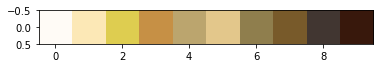

In [390]:
# Comentar para evitar quebra o código
# t = dfPorAno[7][['r','g','b']].to_records(index=False)
# plt.imshow([t.tolist()])
# plt.show()

### Salvar paletas

In [299]:
#Paleta Geral
paletaAnos.to_csv(f'paletas\\final_artistas\\paleta_{artistName}.csv', index=False)
#Paleta por ano

# Ver qual melhor formato salvar para poder carregar no grafico

# Passo 3 - Quantificar de acordo com paleta

### 1. Leitura da paleta

In [15]:
paletaCores = pd.read_csv(f'paletas\\final_artistas\\paleta_{artistName}.csv')
paletaCores['hex'] = paletaCores.apply( lambda row: rgb2hex(row['r'], row['g'], row['b']), axis=1)

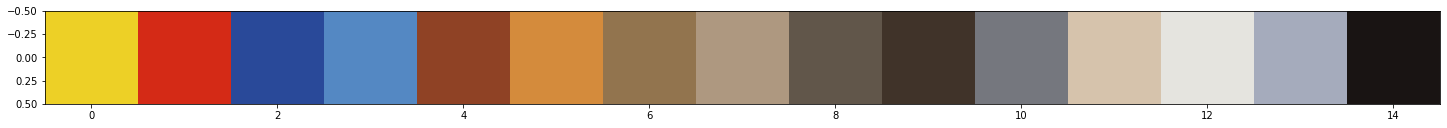

In [302]:
# Mostra imagem da paleta --> comentar antes de usar pode quebrar os código, pois transforma int em numpy int
t = paletaCores[['r','g','b']].to_records(index=False)
plt.figure(figsize = (25,4))
plt.imshow([t.tolist()])
plt.show()


### 2. Classificação de acordo com a paleta -> Uso de k-neighbour

In [304]:
#Calcula a frequencia de cores de um obra
def calculoImagem(path, classificador):
    image = img.imread(path)

    #Constroi dataframe de cores
    df = pd.DataFrame()
    df['r']=pd.Series(image[:,:,0].flatten())
    df['g']=pd.Series(image[:,:,1].flatten())
    df['b']=pd.Series(image[:,:,2].flatten())

    colorClassification = classificador.kneighbors(df[['r', 'g', 'b']],return_distance=False)
    return colorClassification.flatten()

In [305]:
def calculaFreqCores(arrayFrequencia):

    #Calcula frequencia e porcentagem de cores
    unique, counts = np.unique(arrayFrequencia, return_counts=True)
    frequenciaCor = np.asarray((unique, counts)).T

    normalizedFreq = np.zeros(len(paletaCores))

   # Normaliza frenquencia de cores 
    # for index, count in frequenciaCor:
    #     normalizedFreq[index] = round(count/ len(arrayFrequencia), 4)
    

    for index, count in frequenciaCor:
       normalizedFreq[index] = count   

    return normalizedFreq    


In [16]:
# Criando classificador baseado na paleta
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(paletaCores[['r', 'g', 'b']])

NearestNeighbors(n_neighbors=1)

In [306]:
freqAnos = []
for ano in anos:
    
    #Calcular a frequencia de cores de obras de um ano
    pathAnos = pathArtista + ano
    listaObras = [join(pathAnos, f) for f in os.listdir(pathAnos) if isfile(join(pathAnos, f))]

    classificoesAno = []
    for pathObra in listaObras:
        imagemClassificacao = calculoImagem(pathObra, neigh)
        classificoesAno.append(imagemClassificacao)
        
    frequenciasCoresAno = np.concatenate(classificoesAno)
    freqAnos.append(calculaFreqCores(frequenciasCoresAno))
    
freqAnosArray = np.stack(freqAnos, axis=1)
freqAnosArray.shape


(15, 33)

### 3. Salvar em arquivo

In [320]:
dfSalvar = pd.DataFrame(freqAnosArray, columns=anos)
dfSalvar.to_csv(f'dataset_visualizacoes\\{artistName}\\area.csv', index=False)

# Testes de gráficos

In [321]:
#Teste de como vai ficar o gráfico
x=anos
fig = go.Figure()

for index in range(len(freqAnosArray)):
    print(index, freqAnosArray[index])
    fig.add_trace(go.Scatter(
        x=x, y=freqAnosArray[index],
        mode='lines',
        line=dict(width=0.5, color=paletaCores['hex'][index]),
        fillcolor = paletaCores['hex'][index],
        stackgroup='one',
        groupnorm='percent' # sets the normalization for the sum of the stackgroup
    ))


fig.update_layout(
    showlegend=True,
    xaxis_type='category',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()

0 [0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 0.0000e+00 0.0000e+00
 1.8960e+03 8.9460e+03 2.4140e+03 1.5080e+03 1.9422e+04 1.8040e+03
 9.1700e+02 1.9170e+03 5.4000e+01 5.5000e+01 1.2726e+04 1.0000e+00
 1.5800e+02 1.0209e+04 8.6210e+03 4.5060e+03 1.5858e+04 6.3400e+02
 2.0130e+03 0.0000e+00 3.0460e+03 2.8110e+03 0.0000e+00 0.0000e+00
 3.7302e+04 3.8864e+04 6.0480e+03]
1 [0.0000e+00 0.0000e+00 8.0060e+03 1.3070e+03 0.0000e+00 0.0000e+00
 9.8400e+02 0.0000e+00 9.0000e+00 0.0000e+00 4.9579e+04 1.5230e+03
 2.5902e+04 3.0890e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.4654e+04
 0.0000e+00 0.0000e+00 8.4255e+04 6.4500e+02 1.3488e+04 1.9820e+03
 8.9197e+04 1.5266e+04 1.7840e+04 0.0000e+00 0.0000e+00 1.1100e+02
 9.1840e+03 6.8820e+03 4.8830e+03]
2 [0.00000e+00 3.00000e+00 1.66230e+04 6.00000e+01 1.90000e+01 2.05420e+04
 5.64000e+02 0.00000e+00 3.20000e+01 1.49000e+02 6.80000e+02 1.08610e+04
 2.52628e+05 1.63594e+05 0.00000e+00 0.00000e+00 6.00000e+00 6.41000e+03
 0.00000e+00 2.60000e+01 6.25300e+0

In [40]:
dfPorAno[3]

,r,g,b,ordem,hex
0,215,131,59,93,#D7833B
1,104,93,85,98,#685D55
2,140,122,99,99,#8C7A63
3,163,92,37,102,#A35C25
4,100,46,29,103,#642E1D
5,70,62,60,104,#463E3C
6,125,129,151,107,#7D8197
7,167,163,160,108,#A7A3A0
8,215,207,213,110,#D7CFD5
9,53,25,21,119,#351915


In [53]:
x=anos

fig = go.Figure()

for index, ano in zip(range(len(anos)),dfPorAno):
    y =  [0] * len(anos)
    y[index] = 3
    for indexDf in range(len(ano)):
        fig.add_trace(go.Bar(x=x, y=y, marker_color=ano['hex'][indexDf]))

# fig = go.Figure(go.Bar(x=x, y=[4,0,0,0], marker_color='red', name='Montreal'))
# fig.add_trace(go.Bar(x=x, y=[4, 0, 0, 0], name='Ottawa'))
# fig.add_trace(go.Bar(x=x, y=[0, 4, 0, 0], name='Toronto'))
# fig.add_trace(go.Bar(x=x, y=[0, 4, 0, 0], name='Toronto'))

fig.update_layout(barmode='stack')
fig.show()

# Testes

In [ ]:
dfList = []
# dfList.append(pd.read_json('dataset_artistas/andy-warhol.json', orient='records'))
# dfList.append(pd.read_json('dataset_artistas/frida-kahlo.json', orient='records'))
# dfList.append(pd.read_json('dataset_artistas/sandro-botticelli.json', orient='records'))
# dfList.append(pd.read_json('dataset_artistas/vincent-van-gogh.json', orient='records'))
dfList.append(pd.read_json('dataset_artistas/pablo-picasso.json', orient='records'))

df = pd.concat(dfList, ignore_index=True)
# df.head()


df[df['genre'] != 'sketch and study']['completitionYear'].value_counts()



# df[df.duplicated(['artistName'], keep=False)]


In [ ]:
# Informacoes do artista

dfListArtist = pd.read_json('dataset_artistas/artists.json', orient='records')
dfListArtist

